In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc
from dash import html
from jupyter_dash import JupyterDash

## Result Generation

Default params from the emulator source are 8, 6, 4, 2, and 8 respectively. Keep `MAXLUTS` and `MAXREGS` at their defaults for now and sweep `MAXPUSH` & `MAXAPS` from $2\rightarrow 9$ and `APSIZE` $3\rightarrow 9$.

In [ ]:
emu_cmd = lambda example, file, MAXPUSH, APSIZE, MAXAPS, MAXLUTS, MAXREGS :\
  f'~/Sync/haflang/reduceron/flite/dist/build/flite/flite -s -i{MAXAPS} -r{MAXPUSH}:{APSIZE}:{MAXAPS}:{MAXLUTS}:{MAXREGS} {example}/{file} | ~/Sync/haflang/tommythorn_reduceron/emulator/emu -v -'

runs = []
for maxpush in range(2,10):
    for apsize in range(3,10):
        for maxaps in range(2, 10):
            for example in ['mss', 'mate', 'fib', 'adjoxo']:
                for src_file in ['orig.fl','ghc_noopt.fl', 'ghc_o2.fl']:
                    cmd = emu_cmd(example,src_file,maxpush, apsize, maxaps, 2, 8)
                    stats_raw = !$cmd
                    stats = dict([line.replace(" ", "").split('=') for line in stats_raw[2:-1]])
                    stats.update({'MAXPUSH' : maxpush, 'APSIZE' : apsize, 'MAXAPS' : maxaps, 'source': src_file, 'example' : example})
                    runs.append(stats)
                    print(stats)

df = pd.DataFrame(runs)
df.to_csv('param_sweep.csv')

## Analysis

In [7]:
df = pd.read_csv('param_sweep.csv')

df = df.drop_duplicates(subset=['MAXPUSH', 'APSIZE', 'MAXAPS', 'source', 'example'])
df['MTicks'] = df['Ticks'].map(lambda x : float(x)/1000000.0)
for key in ['Swap', 'Prim', 'Unwind', 'Update', 'Apply', 'PRSSuccess']:
    df[key] = df[key].map(lambda x : float(str(x)[:-1])/100.0)
    df[key+'Ticks'] = df.apply(lambda row : row[key]/100.0*row['Ticks'], axis=1)

In [8]:
import plotly.graph_objects as go # or plotly.express as px

app = JupyterDash()

fig = go.Figure()
app.layout = html.Div([
    html.Div(
        [
            dcc.Dropdown(
                id='comparison',
                options=[{
                    'label': i,
                    'value': i
                } for i in ['MAXPUSH-MAXAPS','MAXPUSH-APSIZE','MAXAPS-APSIZE']],
                value='MAXPUSH-APSIZE',
                style={'min-width':200, 'max-width':'30%', 'margin-right':'3%'}),
            dcc.Dropdown(
                id='zkey',
                options=[{
                    'label': i,
                    'value': i
                } for i in ['MTicks','MaxHeap','MaxStack','MaxUStack','MaxLStack',
                            'Swap', 'Prim', 'Unwind', 'Update', 'Apply', 'PRSSuccess',
                            'SwapTicks', 'PrimTicks', 'UnwindTicks', 'UpdateTicks', 'ApplyTicks', 'PRSSuccessTicks']],
                value='MTicks',
                style={'min-width':200, 'max-width':'30%','margin-right':'3%'}),
            dcc.Dropdown(
                id='sources',
                options=[{
                    'label': i,
                    'value': i
                } for i in ['orig.fl','ghc_noopt.fl','ghc_o2.fl']],
                value=['orig.fl'],
                multi=True,
                style={'min-width':200, 'max-width':'30%','margin-right':'3%'}),
            dcc.Dropdown(
                id='example',
                options=[{
                    'label': i,
                    'value': i
                } for i in ['adjoxo','mate','mss', 'fib']],
                value='adjoxo',
                style={'min-width':200, 'max-width':'30%','margin-right':'3%'}),
            html.Div([dcc.RangeSlider(id='constrange', min=3, max=9, step=1, value=[3,9])],
                     style={'min-width':200, 'max-width':'30%'})
        ],
        style={'width': '100%',
               'display': 'flex'}),
    dcc.Graph(id='surfplot', figure=fig),
])


@app.callback(
    dash.dependencies.Output('surfplot', 'figure'),
    [dash.dependencies.Input('comparison', 'value'),
     dash.dependencies.Input('zkey', 'value'),
     dash.dependencies.Input('constrange', 'value'),
     dash.dependencies.Input('sources', 'value'),
     dash.dependencies.Input('example', 'value')])
def update_graph(comparison, zkey, consts_range, sources, example):
    (xkey,ykey) = comparison.split('-')
    constkey = list(set(['MAXPUSH','MAXAPS','APSIZE'])-set([xkey,ykey]))[0]

    planes = [ go.Surface(name=f'{constkey}@{const}',
                          showscale=False, opacity=1.0,
                          colorscale=colours,
                          x=list(set(df[xkey].values)),
                          y=list(set(df[ykey].values)),
                          z=df[(df[constkey]==const) & (df['source']==source) & (df['example']==example)].pivot(index=xkey, columns=ykey, values=zkey).values)  \
               for const in range(consts_range[0],consts_range[1]+1) \
               for (source,colours) in zip(sources,colour_schemes) ]
    
    return {
        'data': planes,
        'layout': go.Layout(
            width=1000, height=800,
            autosize=True, uirevision='keep',
            scene = dict(xaxis={'title': xkey},
                         yaxis={'title': ykey},
                         zaxis={'title': zkey})
        )
    }

colour_schemes = ['Picnic','YlGnBu','Greens','YlOrRd','Bluered','RdBu','Reds','Blues']
app.run_server(debug=True, use_reloader=False)

Dash app running on http://127.0.0.1:8050/


## Explaining the differences between PilGRIM and Reduceron benchmarks

Want to run _all_ the examples with settings comparable to PilGRIM. Want to generate a normalised bar chart where we can compare the reduceron slowdown to % of time in various sorts of instructions.



In [ ]:
emu_cmd = lambda example, MAXPUSH, APSIZE, MAXAPS, MAXLUTS, MAXREGS :\
  f'~/Sync/haflang/reduceron/flite/dist/build/flite/flite -s -i{MAXAPS} -r{MAXPUSH}:{APSIZE}:{MAXAPS}:{MAXLUTS}:{MAXREGS} ~/Sync/haflang/tommythorn_reduceron/programs/{example} | ~/Sync/haflang/tommythorn_reduceron/emulator/emu -v -'

examples = [
   'Adjoxo.hs'
  ,'Braun.hs'
  ,'Cichelli.hs'
  ,'Clausify.hs'
  ,'CountDown.hs'
  ,'KnuthBendix.hs'
  ,'Mate.hs'
  ,'MSS.hs'
  ,'OrdList.hs'
  ,'PermSort.hs'
  ,'Queens2.hs'
  ,'Queens.hs'
  ,'SumPuz.hs'
  ,'Taut.hs'
  ,'While.hs'
]
                
runs = []
for example in examples:
        cmd = emu_cmd(example, 8,6,4,2,4) #emu_cmd(example, 4, 7, 1, 4, 16)
        stats_raw = !$cmd
        stats = dict([line.replace(" ", "").split('=') for line in stats_raw[2:-1]])
        stats.update({'example' : example})
        runs.append(stats)
        print(stats)

df = pd.DataFrame(runs)
df.to_csv('pilgrim_comparison.csv')

In [4]:
df = pd.read_csv('pilgrim_comparison.csv')
df['MTicks'] = df['Ticks'].map(lambda x : float(x)/1000000.0)
for key in ['Swap', 'Prim', 'Unwind', 'Update', 'Apply', 'PRSSuccess']:
    df[key] = df[key].map(lambda x : float(str(x)[:-1])/100.0)
    df[key+'Ticks'] = df.apply(lambda row : row[key]/100.0*row['Ticks'], axis=1)

Should I be accounting for GC time, or is that not emulated? PilGRIM numbers do not include this.

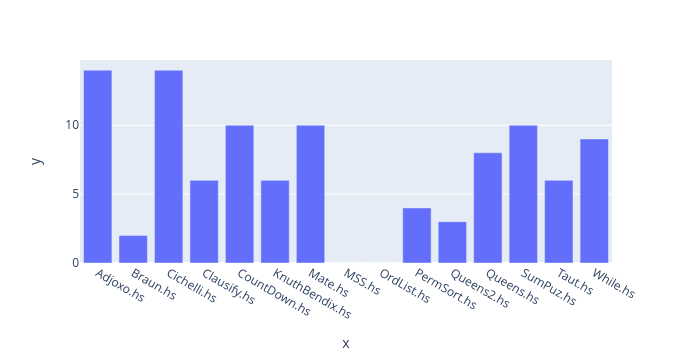

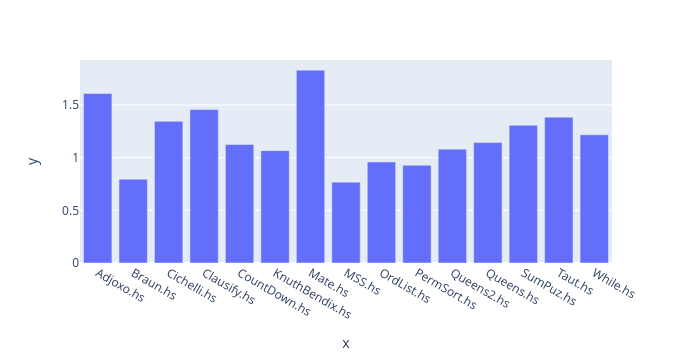

In [6]:
# From paper: Introducing the PilGRIM
exampleTickComparisons = [
   # Example, Pilgrim MTicks, Reduceron MTicks, Pilgrim %PrimOps, Pilgrim %NodeStores
   ('Adjoxo.hs'     , 23 , 37 , 23, 13)
  ,('Braun.hs'      , 83 , 66 , 2 , 35)
  ,('Cichelli.hs'   , 29 , 39 , 19, 6)
  ,('Clausify.hs'   , 46 , 67 , 5 , 17)
  ,('CountDown.hs'  , 16 , 18 , 25, 17)
  ,('KnuthBendix.hs', 15 , 16 , 8 , 18)
  ,('Mate.hs'       , 343, 628, 15, 6)
  ,('MSS.hs'        , 86 , 66 , 24, 1)
  ,('OrdList.hs'    , 98 , 94 , 0 , 32)
  ,('PermSort.hs'   , 166, 154, 4 , 34)
  ,('Queens2.hs'    , 111, 120, 0 , 32)
  ,('Queens.hs'     , 84 , 96 , 42, 10)
  ,('SumPuz.hs'     , 277, 362, 12, 18)
  ,('Taut.hs'       , 39 , 54 , 5 , 18)
  ,('While.hs'      , 46 , 56 , 9 , 24)
]
examples = [name for (name,_,_,_,_) in exampleTickComparisons]

safe_div = lambda x, y : x / y if y != 0 else 0

#px.bar(x=examples, y=df['Prim'].values).show()
px.bar(x=examples, y=[safe_div(a*100.0, 1) for (red_prim,(_,p,r,a,_)) in zip(df['Prim'],exampleTickComparisons)]).show()
px.bar(x=examples, y=[float(r)/p for (_,p,r,_,_) in exampleTickComparisons]).show()